In [1]:
import ic_sets, auction_data, os
hist_plot = auction_data.hist_plot
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style('white')
%matplotlib inline

In [2]:
tsuchiura_data = auction_data.AuctionData('tests/reference_data/tsuchiura_data.csv')
ic_set = ic_sets.ICSets(rho_p=.001, rho_m=.05, auction_data=tsuchiura_data, 
                           k=.1, t=.05, m=.5)

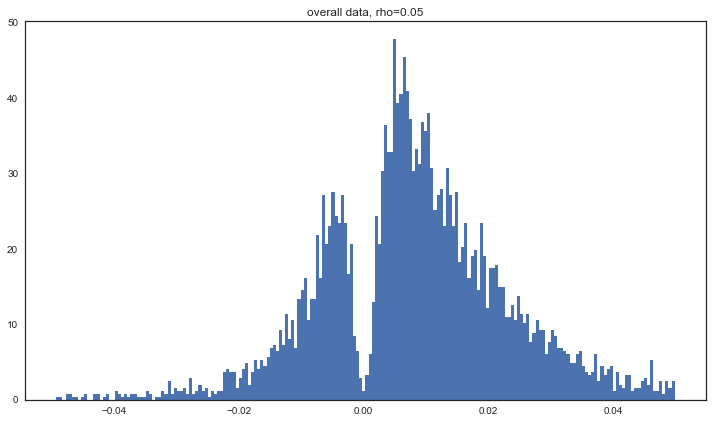

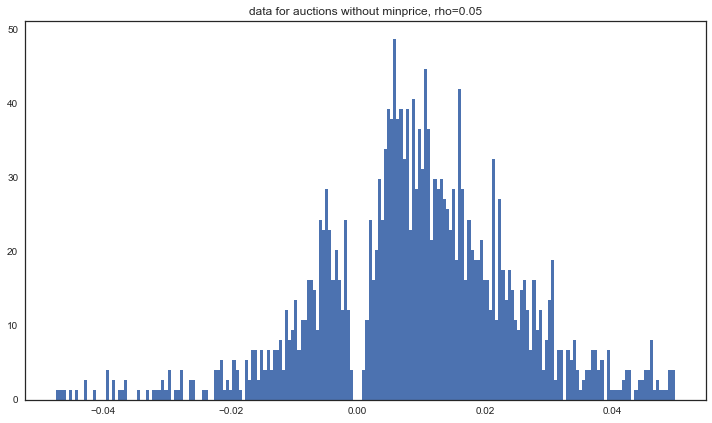

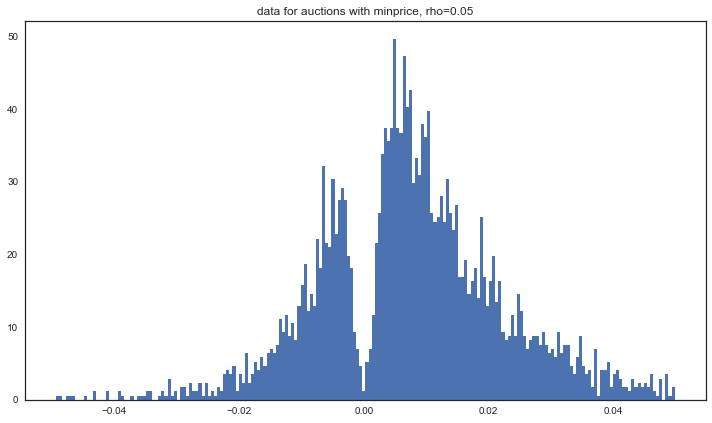

In [3]:
delta = tsuchiura_data.df_bids.norm_bid - tsuchiura_data.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta,'overall data, rho={}'.format(rho))
hist_plot(delta[tsuchiura_data.df_bids.minprice.isnull()], 
          'data for auctions without minprice, rho={}'.format(rho))
hist_plot(delta[~tsuchiura_data.df_bids.minprice.isnull()], 
          'data for auctions with minprice, rho={}'.format(rho))

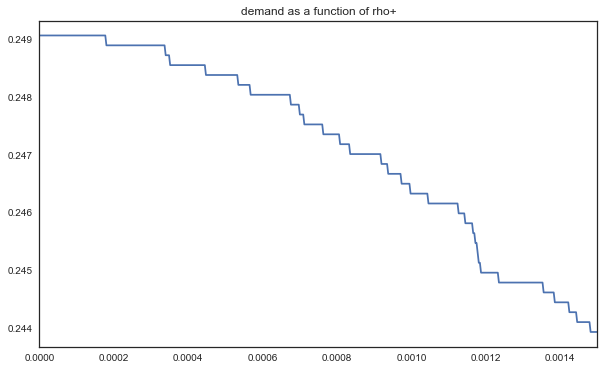

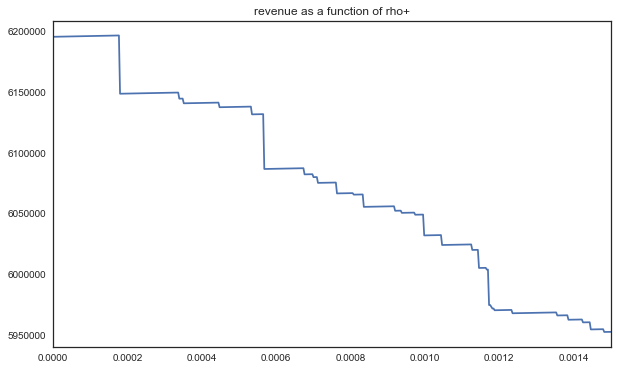

In [4]:
tsuchiura_data.get_counterfactual_demand(.0015,.0).demand.plot(figsize = (10,6))
plt.title('demand as a function of rho+')
plt.show()

tsuchiura_data.get_counterfactual_demand(.0015,.0).revenue.plot(figsize = (10,6))
plt.title('revenue as a function of rho+')
plt.show()

## Test: inference from upper deviation alone as $m$ varies

This should be equivalent to the case where there are no information constraints

## Test: inference from upper and lower deviations as $m$ varies -- i.i.d. case

In [5]:
# for m in np.linspace(.1, 1, .05):
tsuchiura_data = auction_data.AuctionData('tests/reference_data/tsuchiura_data.csv')

ic_solver = ic_sets.ICSets(rho_p=.001, rho_m=.001, auction_data=tsuchiura_data, 
                           k=0, t=.0, m=.5)

ic_solver.set_tolerance_parameters(m=.5)

steps = np.linspace(0, 1, 5)
list_p_c = list(itertools.product(steps, repeat=4))

data = []
index = []

for i, test_pc in enumerate(list_p_c):
    is_rationalizable_iid = ic_solver.is_rationalizable_iid(test_pc)
    is_rationalizable = ic_solver.is_rationalizable(test_pc)
    index.append(i)
    data.append([is_rationalizable, is_rationalizable_iid])

df_match = pd.DataFrame(data=data, index=index, columns=['iid', 'general'])

In [6]:
list_p_c[30]

(0.0, 0.25, 0.25, 0.0)

In [7]:
ic_solver.is_rationalizable(list_p_c[30])

False

In [8]:
np.where(df_match['iid'] != df_match['general'])

(array([], dtype=int64),)

In [9]:
import random
random.seed(888)

In [10]:
np.random.seed(888)
a = np.random.randn(3,56)

In [11]:
np.concatenate((a, a), axis=0).shape

(6, 56)

(0, 0.002)

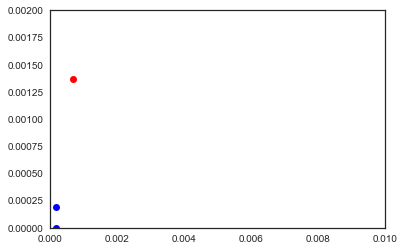

In [12]:
plt.plot([0.00068376], [0.00136752], 'ro')
plt.plot([3.11324786e-02, 6.22649573e-02, 3.11324786e-02, 6.22649573e-02, 1.86236163e-04, 1.86236163e-04],
         [0.00000000e+00, 0.00000000e+00, 9.37735043e-01, 9.37735043e-01, 0.00000000e+00, 1.87356943e-04],    
         'bo')
plt.xlim(0,.01)
plt.ylim(0, 0.002)

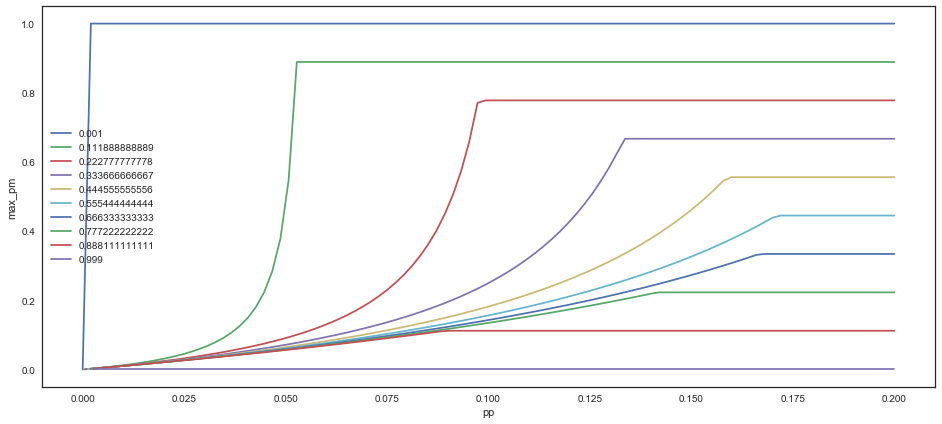

In [13]:

legend = []
plt.figure(figsize=(16,7))
for d in np.linspace(0.001, .999, 10):
    range_pp = np.linspace(ic_solver.lower_slope_pp * d, .2, 100)
    max_pm = [ic_solver.value_pm(d, pp) for pp in range_pp]
    plt.plot(range_pp, max_pm)
    legend.append(d)
plt.legend(legend)
plt.xlabel('pp')
plt.ylabel('max_pm')


plt.show()

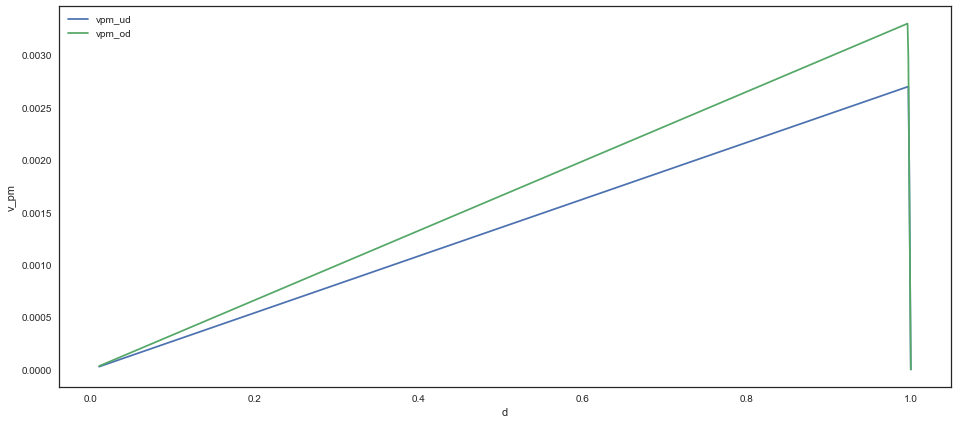

In [14]:
legend = ['vpm_ud', 'vpm_od']
plt.figure(figsize=(16,7))
u_d_val = []
o_d_val = []
d_range = np.linspace(0.01, 1., 1000) 
for d in d_range:
    u_d, o_d = .9 * d, 1.1 * d
    vpm_ud, vpm_od = (ic_solver.value_pm(d, ic_solver.lower_slope_pp * d_) for d_ in [u_d, o_d])
    u_d_val.append(vpm_ud)
    o_d_val.append(vpm_od)
plt.plot(d_range, u_d_val)
plt.plot(d_range, o_d_val)
plt.legend(legend)
plt.xlabel('d')
plt.ylabel('v_pm')

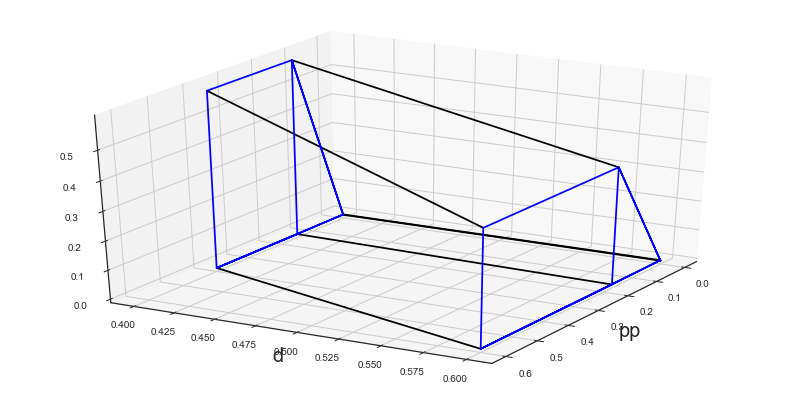

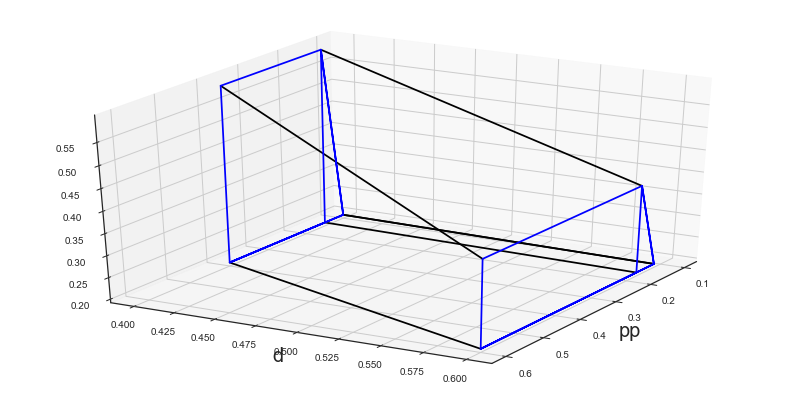

In [15]:
ic_solver.plot_z(.4, .6, .0)
ic_solver.plot_z(.4, .6, .2)
plt.show()

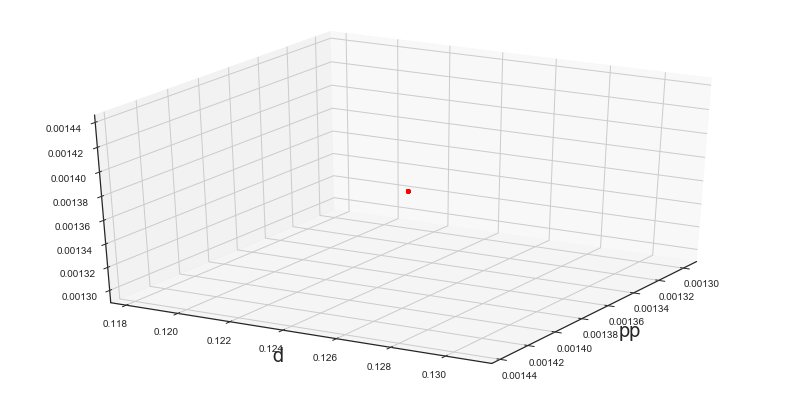

In [16]:
p_c = (.5, .5, .5, .5)
b = ic_solver.compute_set_b(p_c)
ic_solver.plot_box(b)

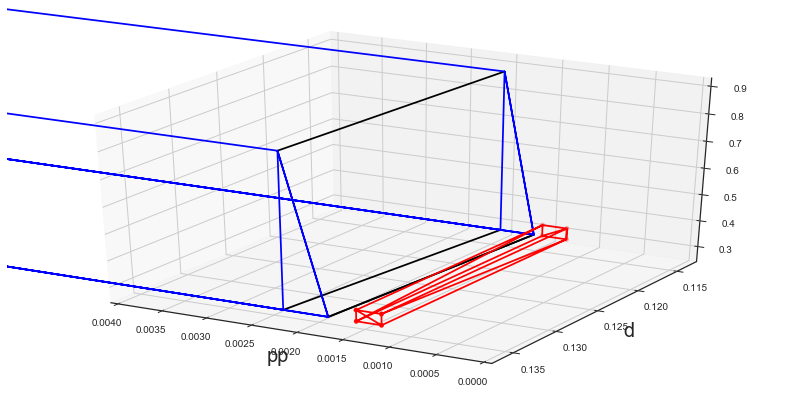

In [17]:
ic_set.is_rationalizable(p_c, 'plot')
plt.xlim(0, .004)
plt.show()

In [18]:
reload(ic_sets)
ic_set.get_box_extreme_points(ic_set.compute_set_b(p_c))

array([[ 0.11403066,  0.28484018,  0.00123755],
       [ 0.11403066,  0.28484018,  0.00151113],
       [ 0.11403066,  0.32726576,  0.00123755],
       [ 0.11403066,  0.32726576,  0.00151113],
       [ 0.13584765,  0.28484018,  0.00123755],
       [ 0.13584765,  0.28484018,  0.00151113],
       [ 0.13584765,  0.32726576,  0.00123755],
       [ 0.13584765,  0.32726576,  0.00151113]])

In [19]:
ic_set.extreme_points_set_z(0.11403066, 0.13584765, 0.00123755)

array([[  1.14030660e-01,   1.23755000e-03,   3.41068774e-04],
       [  1.14030660e-01,   2.01230576e-02,   3.41068774e-04],
       [  1.14030660e-01,   1.23755000e-03,   1.98537377e-03],
       [  1.14030660e-01,   8.85969340e-01,   1.98537377e-03],
       [  1.14030660e-01,   1.23755000e-03,   1.14030660e-01],
       [  1.14030660e-01,   8.85969340e-01,   1.14030660e-01],
       [  1.35847650e-01,   1.23755000e-03,   4.06323978e-04],
       [  1.35847650e-01,   2.39731147e-02,   4.06323978e-04],
       [  1.35847650e-01,   1.23755000e-03,   2.30797252e-03],
       [  1.35847650e-01,   8.64152350e-01,   2.30797252e-03],
       [  1.35847650e-01,   1.23755000e-03,   1.35847650e-01],
       [  1.35847650e-01,   8.64152350e-01,   1.35847650e-01]])

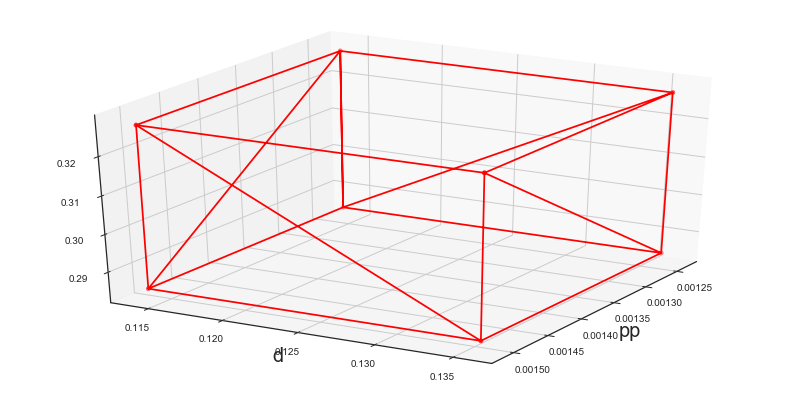

In [21]:
ic_set.plot_box(ic_set.compute_set_b(p_c))